# Machine Vision and Cognitive Robotics - Exercise 4

<!-- 
Automation and Control Institute - TU Wien
Matthias Hirschmanner 2019
machinevision@acin.tuwien.ac.at
 -->

In this exercise you will implement a neural network to classify images of the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). It consists of 60000 images with a resolution of 32x32. The different classes and example images for each classes are shown in Figure 1 below. We will use the library Keras with the TensorFlow backend to create our neural networks. More specifically, we will use the Functional API of Keras. 


![Classes of CIFAR10](https://i2.wp.com/appliedmachinelearning.blog/wp-content/uploads/2018/03/cifar2.jpg?resize=427%2C325&ssl=1)

Figure 1: Examples of the different classes of the CIFAR10 dataset.

---



Please keep the code in the sections below clean and only change it in the dedicated areas. You shouldn't need to change it anywhere else. You also shouldn't need to use any additional libraries other than the ones already imported. If you need to change the code somewhere else or need to import a different library to get a functioning program, that might be a bug. Please report it in the Tuwel forum or send us a mail to machinevision@acin.tuwien.ac.at


## Import Libraries
In a first step we import the libraries needed for the exercise. Please execute the cell below.

In [1]:
# Sets the tensorflow version. If you use conda, you might need to delete this line
import numpy as np
from matplotlib import pyplot as plt
import random
import requests
import imageio
from PIL import Image
from typing import Tuple

from tensorflow import Tensor

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks 

import tensorflow.keras.utils 
import tensorflow.keras.backend as K
from tensorflow.python.client import device_lib

# Fixes a crash when running on Mac OS
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

get_ipython().__class__.__name__ = "ZMQInteractiveShell"

print("These devices are available. If no GPU shows up in Google Colab, \
change Runtime type to GPU.")
print(device_lib.list_local_devices())


These devices are available. If no GPU shows up in Google Colab, change Runtime type to GPU.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15051176306765299119
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3305928346016584767
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13753982412881714977
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12539036950523925922
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Load Dataset
Next we load the CIFAR10 dataset. The training images are in the numpy array `X_train` and the test images in the numpy array `X_test`. The labels are contained in the numpy arrays `y_train`and `y_test`.


In [2]:
# Load datasetlassify images of the CI
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Print shape of arrays:
print('Training Images Shape:', X_train.shape, 'Data Type:', X_train.dtype)
print('Test Images Shape:', X_test.shape)
print('Training Labels Shape:', y_train.shape)
print('Test Labels Shape:', y_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
Training Images Shape: (50000, 32, 32, 3) Data Type: uint8
Test Images Shape: (10000, 32, 32, 3)
Training Labels Shape: (50000, 1)
Test Labels Shape: (10000, 1)


## Plot random images

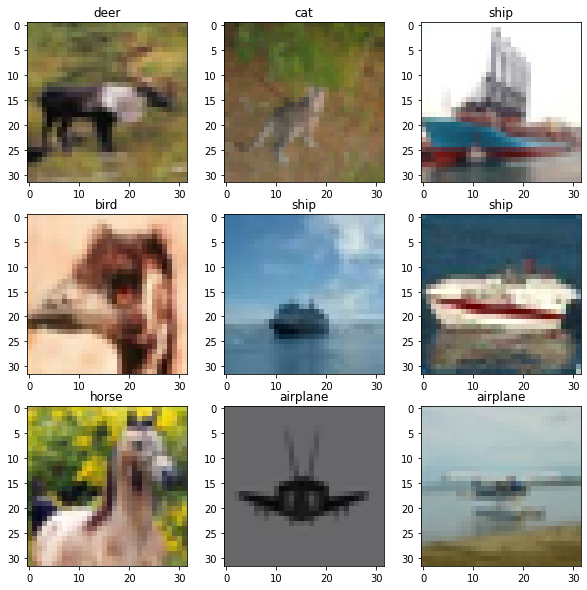

In [3]:
#@title Run this cell!
#@markdown It will show you 9 random images of the dataset. 
#@markdown The code itself is not relevant, but it is important for later to execute this cell because some plotting functions are defined here. 
fig, axs = plt.subplots(3, 3,figsize=(10,10))
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
random_indices = np.random.randint(X_test.shape[0], size=9)
for (idx,ax) in zip(random_indices,axs.flat):
  ax.set_title(labels[y_test[idx,0]])
  ax.imshow(X_test[idx])
  
#Function to plot the training
def plot_history(history):

  # Plot the Training History
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  fig.suptitle('MLP Training')
  ax1.plot(history.history['accuracy'], label="Train")
  ax1.plot(history.history['val_accuracy'], label="Test")
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax1.legend(loc="upper left")
  ax2.plot(history.history['loss'], label='Train')
  ax2.plot(history.history['val_loss'], label='Test')
  ax2.set(xlabel='Epoch', ylabel='Loss')
  ax2.legend(loc="upper right")


#Function corect/wrong recognition:
def plot_predictions(data, model_name, class_name=None):
  labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
  labels_inv = {v: k for k, v in labels.items()}
  y_predictions = model_name.predict(data) 

  # Get the predicted labels [0,9]
  y_predictions_labels = np.argmax(y_predictions,axis=1)
  y_predictions[y_predictions<0.5]=0 # prediction rate R

# getting a list of ALL images and labels with predicion rate R 
  out_ind = np.nonzero(y_predictions) # index of non zero
  out_ind_label = out_ind[1] # index of a label 0-9
  out_ind_image = out_ind[0] # index of an image 0...N (N - size of dataset)
  out_images = X_test[out_ind_image]
# getting lists of ONLY correct and wrong predicted images
  true_out_ind = out_ind[0][y_test[out_ind[0]][:,0] == out_ind_label]
  wrong_out_ind = out_ind[0][y_test[out_ind[0]][:,0] != out_ind_label]
# check if class_name defined at all  (1.'if' if class_name defined, 2.'if' if class_name from the labels list)
  if class_name:
    class_number = labels_inv.get(class_name, -1)
    if class_number != -1: # taking only predictions with defined class_name 

      # Images that were correctly predicted with class_name
      true_out_ind = true_out_ind[y_predictions_labels[true_out_ind]==class_number]
      
      # Images that are part of class_name, but were wrongly predicted
      false_positive_ind = wrong_out_ind[y_predictions_labels[wrong_out_ind]==class_number]

      # Images that are part of class_name but were wrongly predicted
      false_negative_ind = wrong_out_ind[y_test[wrong_out_ind][:,0]==class_number]
      print('Number of correct recognized', class_name, 'images is', len(true_out_ind))
      print('Number of images recognized as', class_name, 'but are not of that class is', len(false_positive_ind))
      print('Number of images not recognized as', class_name, 'but actually are of that class is', len(false_negative_ind))

    else:
      print('No such class like', class_name + '. Check class name again.')
  else:  
    print('Number of correct recognized images is', len(true_out_ind))
    print('Number of wrong recognized images is', len(wrong_out_ind))
# plot of 10 correct and 10 wrong random recognized images 
  true_ind_plot = random.sample(list(true_out_ind), k=10) # correct
  wrong_ind_plot = random.sample(list(wrong_out_ind), k=10) # wrong
  if class_name:
    if class_number != -1:
      fig = plt.figure(figsize=(20,7.5))

      if len(false_positive_ind) > 10:
        false_positive_ind_plot = random.sample(list(false_positive_ind), k=10) # wrong
      else:
        false_positive_ind_plot = false_positive_ind
      
      if len(false_negative_ind) > 10:
        false_negative_ind_plot = random.sample(list(false_negative_ind), k=10) # wrong
      else:
        false_negative_ind_plot = false_negative_ind

      for idx, image_idx in enumerate(true_ind_plot):
        a = fig.add_subplot(3, 10, idx+1)
        imgplot = plt.imshow(X_test[image_idx])
        a.set_title(labels[y_predictions_labels[image_idx]], color='green', y=-0.2)
        a.axis('off')
      for idx, image_idx in enumerate(false_positive_ind_plot):
        a = fig.add_subplot(3, 10, idx+11)
        imgplot = plt.imshow(X_test[image_idx])
        a.set_title(labels[y_predictions_labels[image_idx]], color='red', y=-0.2)
        a.axis('off')
        a.set_xlabel(labels[y_predictions_labels[image_idx]], color='red')
      for idx, image_idx in enumerate(false_negative_ind_plot):
        a = fig.add_subplot(3, 10, idx+21)
        imgplot = plt.imshow(X_test[image_idx])
        a.set_title(labels[y_predictions_labels[image_idx]], color='red', y=-0.2)
        a.axis('off')
      plt.figtext(0.5,0.9, "Correct Predictions", ha="center", va="top", fontsize=14)
      plt.figtext(0.5,0.63, "False Positives", ha="center", va="top", fontsize=14)
      plt.figtext(0.5,0.36, "False Negatives", ha="center", va="top", fontsize=14)

  else:
    fig = plt.figure(figsize=(20,5))
    for idx, image_idx in enumerate(true_ind_plot):
      a = fig.add_subplot(2, 10, idx+1)
      imgplot = plt.imshow(X_test[image_idx])
      a.set_title(labels[y_predictions_labels[image_idx]], color='green')
    for idx, image_idx in enumerate(wrong_ind_plot):
      a = fig.add_subplot(2, 10, idx+11)
      imgplot = plt.imshow(X_test[image_idx])
      a.set_title(labels[y_predictions_labels[image_idx]], color='red')


# Normalization of an image and training
def predict_image(nn_model, image):
  labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
  # prediction with a model
  test_prediction = nn_model.predict(image) # define a model of nn
  print(test_prediction)
  # top 5 predictions
  out_ind_up = sorted(range(len(list(test_prediction[0]))), key = lambda sub: test_prediction[0][sub])[-5:] 
  # result
  print("Top-5 Predictions:")
  for i in out_ind_up[::-1]:
    print(' ', labels[i].capitalize(), '-', round((test_prediction[0][i])*100,2), '%') 
  
# Load an image from an external URL an returns it
def load_image_link(link): 
  response = requests.get(link)
  im_from_link = Image.fromarray(imageio.imread((response.content))) 
  # Adjust width and height to CIFAR10 resolution
  width = 32
  height = 32
  loaded_image = im_from_link.resize((width, height), Image.ANTIALIAS)
  loaded_image = np.expand_dims(loaded_image, axis = 0)
  return loaded_image

# Load an image from Colab folder
def load_image_colab(image_name): 
  # Default Colab folder: "/content/..."
  imageFile = "/content/" + image_name # taking a file with original size
  im_from_fold = Image.open(imageFile) # if you do it from colab folder
  # Adjust width and height to CIFAR10 resolution
  width = 32
  height = 32
  loaded_image = np.array(im_from_fold.resize((width, height), Image.ANTIALIAS))
  loaded_image = np.expand_dims(loaded_image, axis = 0)
  return loaded_image


## Normalize Images (1 Point)
Your first task is to create the function `normalize_images` which takes the training images `X_train` and the test images `X_test` as parameters. The outputs should be the two normalized sets with the shape `(dataset_size, 32, 32, 3)` and data type `np.float32`. Normalize in a way, that the returned arrays have approximately zero mean ($\mu=0$) and unit variance ($\sigma=1$). You can decide if you want to normalize per color channel or over the whole dataset. Only use the standard numpy functionality to implement this function (e.g. `np.mean()`, `np.var()`, `np.std()`, etc.)

**IMPORTANT:** Use the same mean and and standard deviation you get from the training set also for the test set, because we want our training and test data to go through the same transformation.

You can find more detailed explanation of why we do normalization in this video by Andrew Ng: [Andrew Ng - Normalizing Inputs](https://www.youtube.com/watch?v=FDCfw-YqWTE)

In [4]:
def normalize_images(training_images: np.ndarray, 
                     test_images: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
  """ Normalize training and test images to have zero mean and unit variance

  :param training_images: The training images
  :type training_images: np.ndarray with shape (train_batch_size, width, height, channels)
    and dtype = np.uint8 and values in the range [0, 255]

  :param test_images: The test images
  :type test_images: np.ndarray with shape (test_batch_size, width, height, channels)
    with dtype = np.uint8 and values in the range [0, 255]
  
  :return: (normalized_training_images, normalized_test_images)
    normalized_training_images: Normalized training images with zero mean and unit variance
  :rtype: Tuple(normalized_training_images, normalized_test_images)
    normalized_training_images: np.ndarray with shape (train_batch_size, width, height, channels)
      and dtype = np.float32
    normalized_test_images: np.ndarray with shape (test_batch_size, width, height, channels)
      and dtype = np.float32
  """
  ########## Fix This Part ##########
  normalized_training_images = np.zeros(training_images.shape)
  normalized_test_images = np.zeros(test_images.shape)
  for k in range(3):
    mean = np.mean(training_images[:,:,:,k])
    stddev = np.std(training_images[:,:,:,k])
    normalized_training_images[:,:,:,k] = np.subtract(training_images[:,:,:,k], mean).astype("float32")
    normalized_training_images[:,:,:,k] = np.divide(normalized_training_images[:,:,:,k], stddev)
    normalized_test_images[:,:,:,k] = np.subtract(test_images[:,:,:,k], mean).astype("float32")
    normalized_test_images[:,:,:,k] = np.divide(normalized_test_images[:,:,:,k], stddev)
  
  ###################################

  return normalized_training_images, normalized_test_images

## Preprocess labels (1 Point)
Keras needs the labels as an one-hot encoded vector for training. The function `preprocess_labels(labels, no_of_classes)` should take a label with shape `(batch_size, 1)`, an integer with the number of classes and create a one-hot encoded numpy array with the shape `(batch_size, number_of_classes)`. Keras has the built-in function `tensorflow.keras.utils.to_categorical` which creates this vector for us. For this exercise, don't use it or similar functions.

In [5]:
def preprocess_labels(labels: np.ndarray, 
                      no_of_classes: int) -> np.ndarray:
  """ Return one-hot encoded labels

  :param labels: Labels for each training/test image as a number in the range [0, number_of_classes - 1]
  :type labels: np.ndarray with shape (batch_size, 1) and dtype = np.uint8

  :param no_of_classes: Number of classes in the dataset
  :type no_of_classes: int

  :return output_labels: The one-hot encoded labels. Each label is a vector with 
    all entries = 0 and a single entry = 1 at the index of the correct class. 
  :rtype: np.ndarray with shape (batch_size, no_of_classes) with dtype = np.float32
  """
  ########## Fix This Part ##########
  
  output_labels = np.zeros((labels.shape[0], no_of_classes)).astype("float32")
  for k in range(no_of_classes):
    output_labels[:,k] = np.where(labels[:,0]==k,1,0)

  ###################################
  
  return output_labels



The next cell tests your function with the built-in function of Keras:

In [6]:
y_train_onehot = preprocess_labels(y_train, 10)
y_test_onehot = preprocess_labels(y_test, 10)
if((y_train_onehot == tensorflow.keras.utils.to_categorical(y_train, 10)).all() 
  and (y_test_onehot == tensorflow.keras.utils.to_categorical(y_test,10)).all()):
  print("Test Successful!")
else:
  print("Something went wrong, check your preprocess_labels function")

Test Successful!


##Loss Function (1 Point)
We need a loss function to perform the actual training of our model. Implement the cross-entropy loss with the mathematical functions defined in keras.backend. The function `my_crossentropy_loss` should take the input tensor `y_true` with the one-hot-encoded training labels and the predictions of our network `y_pred` which is a tensor of the same dimensions with the softmax prediction values for each class (between 0 and 1). The shape of the input tensors is `(number_of_predictions, number_of_classes)` and the shape of the output tensor should be `(number_of_predictions,)`. You should use the functions provided in the Keras backend e.g. `K.sum()` (https://www.tensorflow.org/api_docs/python/tf/keras/backend/sum). Don't use the built-in crossentropy loss of Keras. For an example check the code snippet below. The cross-entropy loss is defined as 
\begin{equation}
L(\mathbf{y},\mathbf{\hat{y}})=-\sum_{k=1}^{K}y_{k}\log(\hat{y}_{k}).
\end{equation}

This video gives a good explanation about the cross-entropy loss: https://youtu.be/ueO_Ph0Pyqk

In [8]:
def my_crossentropy_loss(y_true: Tensor, 
                         y_pred: Tensor) -> Tensor:
  """ Calculate the categorical crossentropy loss between the labels and the prediction

  :param y_true: One-hot encoded training labels
  :type y_true: tf.Tensor with shape (batch_size, num_classes) and dtype = np.float32

  :param y_pred: Prediction values of classes in the range [0, 1]
  :type y_pred: tf.Tensor with shape (batch_size, num_classes) and dtype = np.float32

  :return: Categorical crossentropy loss
  :rtype: tf.Tensor with shape (batch_size,) and dtype = np.float32
  """
  ########## Fix This Part ##########
  
  tfm = tensorflow.math
  loss = tfm.reduce_sum(tfm.negative(tfm.multiply(y_true, tfm.log(y_pred))), axis=1)

  ###################################
  
  return loss

  

You can check your implementation by comparing it to the built-in function of Keras. In the example below we have the prediction and true_labels of 4 images with 3 classes:

In [9]:

label_tensor = K.constant([1., 0., 0., \
                           0., 1., 0., \
                           0., 0., 1., \
                           0., 0., 1.], shape=[4,3])

prediction_tensor = K.constant([.9,  .05, .05, \
                                .05, .89, .06, \
                                .5,  .4,  .1,  \
                                .01, .01, .98], shape=[4,3])

my_crossentropy_output = my_crossentropy_loss(label_tensor, prediction_tensor)
keras_crossentropy_output = K.categorical_crossentropy(label_tensor, prediction_tensor)

print('Input shape: ', label_tensor.shape, ' Output Shape: ', my_crossentropy_output.shape)
print('My Crossentropy Loss:    ', K.eval(my_crossentropy_output))
print('Keras built-in function: ', K.eval(keras_crossentropy_output))

Input shape:  (4, 3)  Output Shape:  (4,)
My Crossentropy Loss:     [0.10536055 0.11653383 2.3025851  0.02020269]
Keras built-in function:  [0.10536055 0.11653383 2.3025851  0.02020269]


## Linear Classifier (1 Point)
In a first Step we want to train a simple network with only one layer (no hidden layers). A dense layer takes each input value (each pixel intensity) multiplies it with a weight and adds a bias term for each output neuron. An animation of the process is shown here: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/#3

To be able to feed the images to the network, we need to reshape them to a vector. The function `vectorize_images(images)` takes as input parameter our images as a `numpy.array` with the shape `(batch_size, height, width, color_channels)` and returns a `numpy.array` with the shape `(batch_size, input_dim)`. You can use the function `np.reshape()`.

In [10]:
def vectorize_images(images: np.ndarray) -> np.ndarray:
  """ Reshape images to one-dimensional vectors

  :param images: The input images to be normalized
  :type images: np.ndarray with shape (batch_size, height, width, color_channels)

  :return: The images as one-dimensional arrays
  :rtype: np.ndarray with shape (batch_size, height * width * color_channels)
    and the same datatype as the input images
  """
  ########## Fix This Part ##########

  images_vector = images.reshape(images.shape[0], -1)

  ###################################

  return images_vector


# First normalize our training and test images
X_train_normalized, X_test_normalized = normalize_images(X_train, X_test)

# Now use vectorize_images to create our vectors
X_train_vector = vectorize_images(X_train_normalized)
X_test_vector = vectorize_images(X_test_normalized)

To create the model please use the functional API of Keras since it is more flexible than the sequential model: https://keras.io/getting-started/functional-api-guide/ 

In this part, you should only need to change the arguments of the functions. You can keep the general structure as it is. 

In [15]:
########## Fix This Part ##########

# This returns a tensor
inputs = layers.Input(shape=X_train_vector[0].shape)

# A layer instance is callable on a tensor, and returns a tensor
output_layer = layers.Dense(10, activation="softmax")(inputs)

###################################


# This creates a model that includes
# the Input layer and one Dense layer
one_layer_model = Model(inputs=inputs,
                        outputs=output_layer)

# We compile our model with the Stochastic Gradient Descent as optimizer
# and the cross-entropy loss we implemented earlier
one_layer_model.compile(optimizer='sgd',
              loss=my_crossentropy_loss, 
              metrics=['accuracy'])

one_layer_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


### Actual Training
This command starts the actual training. Make sure you selected the hardware accelarator GPU in Runtime -> Change Runtime type. One epoch should take below 10 seconds.

Run the training for about 30 epochs which should get you to >30% validation accuracy. If the model doesn't go above ~10% (random guessing), check your normalization and the activation function of the `output_layer`.


In [18]:
history_one_layer=one_layer_model.fit(x=X_train_vector, 
                                      y=y_train_onehot, 
                                      validation_data=(X_test_vector, y_test_onehot), 
                                      epochs=30)  # starts training

Epoch 1/30
1563/1563 [==============================] - 4s 2ms/step - loss: 2.0268 - accuracy: 0.3272 - val_loss: 2.0723 - val_accuracy: 0.3378
Epoch 2/30
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9176 - accuracy: 0.3613 - val_loss: 2.0103 - val_accuracy: 0.3270
Epoch 3/30
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8854 - accuracy: 0.3727 - val_loss: 2.1427 - val_accuracy: 0.3192
Epoch 4/30
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8723 - accuracy: 0.3749 - val_loss: 2.1307 - val_accuracy: 0.3382
Epoch 5/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.8593 - accuracy: 0.3798 - val_loss: 2.1091 - val_accuracy: 0.3164
Epoch 6/30
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8529 - accuracy: 0.3845 - val_loss: 2.0165 - val_accuracy: 0.3462
Epoch 7/30
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8402 - accuracy: 0.3847 - val_loss: 2.0608 - val_accuracy:

We can also plot the the training process. Think a bit about what you are seeing here (you will also need to write about it for the documentation).

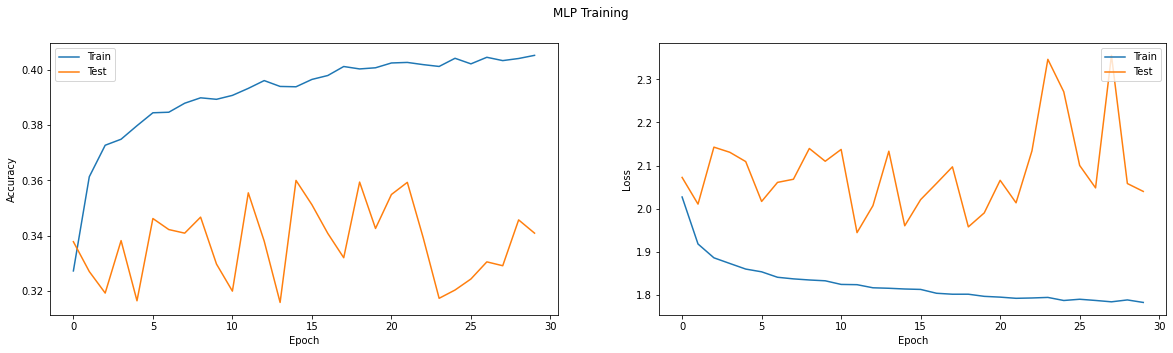

In [19]:
plot_history(history_one_layer)

We can also have a look at some predictions of our model of the test set. The function `plot_predictions(data, model_name, class_name=None)` plots predictions of of random images of the test set with our model. The input data should be X_test preprocessed as the model expects it. By specifying the optional parameter class_name, only correct predictions, false positives and false negatives of this class will be plotted. Feel free to change the parameters below. In the image below you can see an example output of the function with the `class_name='horse'` for a different model.

![alt text](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=1680&y=730&a=true&file=horse_prediction_mlpreg.png&t=0w2rKhrCgTDlMmb&scalingup=0)


Number of correct recognized images is 2136
Number of wrong recognized images is 2741


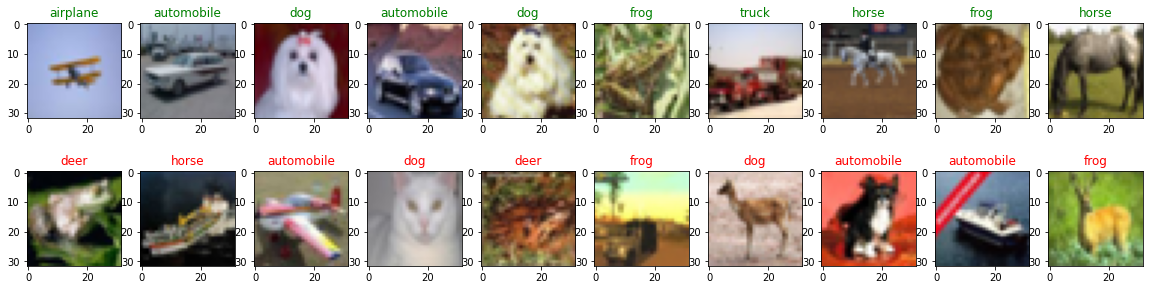

In [21]:
plot_predictions(X_test_vector, one_layer_model)

Number of correct recognized deer images is 167
Number of images recognized as deer but are not of that class is 318
Number of images not recognized as deer but actually are of that class is 210


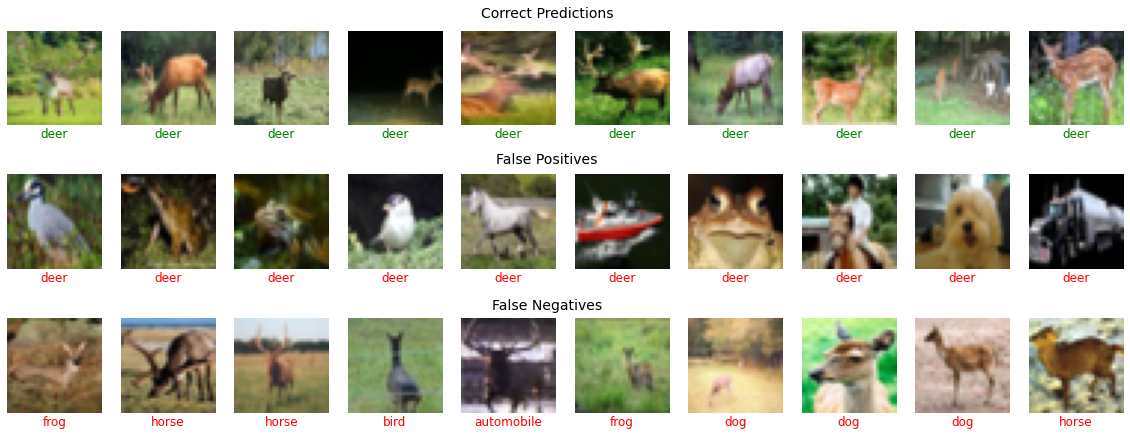

In [24]:
plot_predictions(X_test_vector, one_layer_model, class_name='deer')

## Multilayer Perceptron (1 Point)
The last model with only one layer reached appr. 30% of validation accuracy. It is already better than random guessing but not really satisfactory. Now it's time to add the "Deep" to Deep Learning. Create a model with multiple dense layers (a multilayer perceptron) with ReLu activation in the hidden layers and train it again for about 30 Epochs. The exact structure of the model is up to you, a good starting point is a layer with 256 units, followed by another layer with 128 units and followed by the output layer. This model should reach around 50% of validation accuracy. Training time is dependent on your model but should be below 20s per epoch.

In [11]:
########## Fix This Part ##########

mlp_inputs = layers.Input(shape=X_train_vector[0].shape)

hidden_layer_1 = layers.Dense(256, activation="relu")(mlp_inputs)
hidden_layer_2 = layers.Dense(128, activation="relu")(hidden_layer_1)

mlp_predictions = layers.Dense(10, activation="softmax")(hidden_layer_2)

###################################


mlp_model = Model(inputs = mlp_inputs, outputs = mlp_predictions)
mlp_model.compile(optimizer = 'sgd',
              loss='categorical_crossentropy', # We now use the built-in categorical_crossentropy loss
              metrics=['accuracy'])
history_mlp=mlp_model.fit(x = X_train_vector, 
                          y = y_train_onehot, 
                          validation_data = (X_test_vector, y_test_onehot), 
                          epochs = 30)  # starts training


Epoch 1/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6882 - accuracy: 0.4054 - val_loss: 1.5458 - val_accuracy: 0.4543
Epoch 2/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.4547 - accuracy: 0.4889 - val_loss: 1.4616 - val_accuracy: 0.4821
Epoch 3/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.3501 - accuracy: 0.5271 - val_loss: 1.4234 - val_accuracy: 0.5003
Epoch 4/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.2651 - accuracy: 0.5588 - val_loss: 1.4666 - val_accuracy: 0.4861
Epoch 5/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.1982 - accuracy: 0.5823 - val_loss: 1.4521 - val_accuracy: 0.4882
Epoch 6/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.1385 - accuracy: 0.6053 - val_loss: 1.3921 - val_accuracy: 0.5161
Epoch 7/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.0832 - accuracy: 0.6231 - val_loss: 1.3889 - val_accuracy:

Time again to plot the training. You should now see the effect of overfitting.

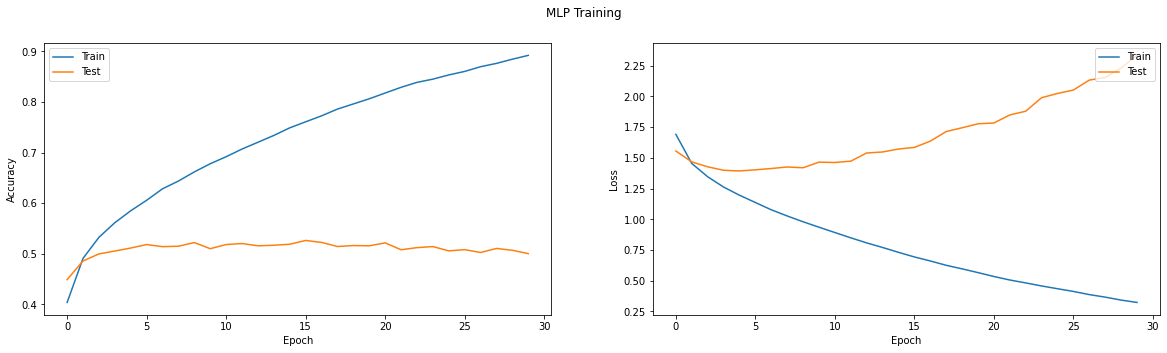

In [120]:
plot_history(history_mlp)

## MLP with Regularization (1 Point)
To counter the problem of overfitting, you should add measures for regularization. Create a new model based on your MLP from the last point which includes at least one regularization technique. It should improve the validation accuracy slightly.

In [76]:
########## Fix This Part ##########

mlpreg_inputs = layers.Input(shape=X_train_vector[0].shape)

dropout_layer_1 = layers.Dropout(0.3)(mlpreg_inputs)
hidden_layer_1 = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-2))(dropout_layer_1)

dropout_layer_2 = layers.Dropout(0.3)(hidden_layer_1)
hidden_layer_2 = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-2))(dropout_layer_2)

mlpreg_predictions = layers.Dense(10, activation="softmax")(hidden_layer_2)

###################################

mlpreg_model = Model(inputs = mlpreg_inputs, outputs = mlpreg_predictions)

# We save the weights here before training to reset them in the experiments part later
mlpreg_model.save_weights('mlpreg_model_weights.h5') 

mlpreg_model.compile(optimizer = 'sgd',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
mlpreg_model.summary()
history_mlpreg = mlpreg_model.fit(x = X_train_vector, 
                          y = y_train_onehot, 
                          validation_data = (X_test_vector, y_test_onehot), 
                          epochs = 30)  # starts training



Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               786688    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
________________________________________________

Let's plot the training process again. If the overfitting is not solved, add additional regularization techniques.

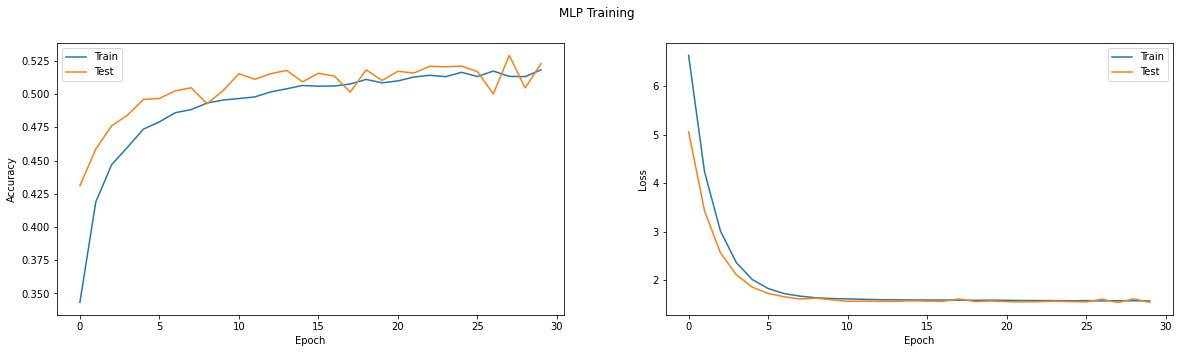

In [129]:
plot_history(history_mlpreg)

We can again plot some predictions.

In [ ]:
plot_predictions(X_test_vector, mlpreg_model, class_name=None)

## Convolutional Neural Network (2 Points)
When converting our images to vectors, all spatial information is lost. A convolutional neural network takes matrices (tensors to be more precise) as input and computes features which make use of spatial information. In this exercise implement a neural network as specified in the image below. Add regularization techniques until you reach at least 75% of validation accuracy with a training time of below 30s per epoch.

Notes: 3x3 Conv X means a Conv2D layer with kernel 3x3 and X units. 
Maxpool /2 means a MaxPool layer with kernel=(2,2) and stride=2.


![Network Architecture](https://owncloud.tuwien.ac.at/index.php/apps/files_sharing/ajax/publicpreview.php?x=3360&y=1178&a=true&file=CNN-architecture.png&t=Ms797G0SEXgeZZe&scalingup=0)

In [25]:
X_train_normalized, X_test_normalized = normalize_images(X_train,X_test)

########## Fix This Part ##########

cnn_inputs = layers.Input(shape=X_train_normalized[0].shape)

conv_layer_1 = layers.Conv2D(32,3,activation="relu")(cnn_inputs)
maxpool_layer_1 = layers.MaxPool2D(strides=2)(conv_layer_1)

dropout_layer_1 = layers.Dropout(0.1)(maxpool_layer_1)
conv_layer_2 = layers.Conv2D(64,3,activation="relu")(dropout_layer_1)
maxpool_layer_2 = layers.MaxPool2D(strides=2)(conv_layer_2)

dropout_layer_2 = layers.Dropout(0.1)(maxpool_layer_2)
conv_layer_3 = layers.Conv2D(128,3,activation="relu")(dropout_layer_2)
globalpool_layer = layers.GlobalAveragePooling2D()(conv_layer_3)

dropout_layer_3 = layers.Dropout(0.3)(globalpool_layer)
dense_layer = layers.Dense(512, activation="relu")(dropout_layer_3)

cnn_predictions = layers.Dense(10, activation="softmax")(dense_layer)

###################################

cnn_model = Model(inputs=cnn_inputs, outputs=cnn_predictions)

# We use the Adam optimizer here which uses more complex methods than our standard SGD
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()
history_cnn=cnn_model.fit(x=X_train_normalized, 
                          y=y_train_onehot, 
                          validation_data=(X_test_normalized, y_test_onehot), 
                          epochs=30)  # starts training

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)         

Plot the training again.

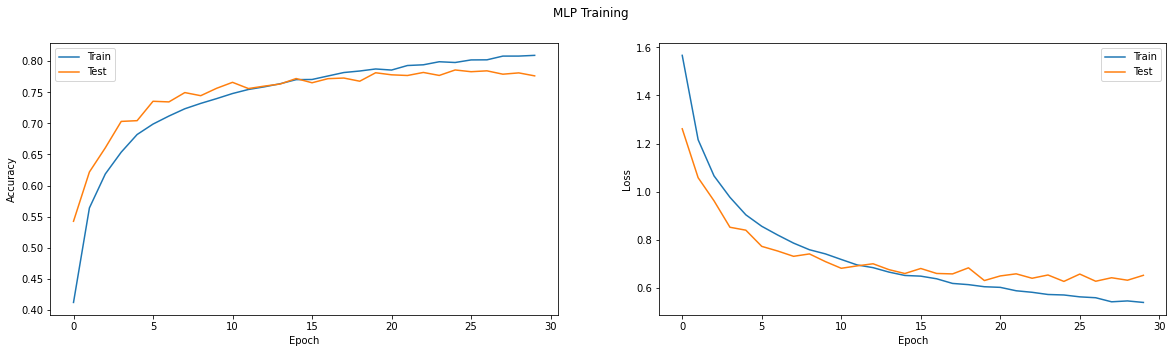

In [26]:
plot_history(history_cnn)

We can again plot some predictions.

Number of correct recognized images is 7229
Number of wrong recognized images is 1317


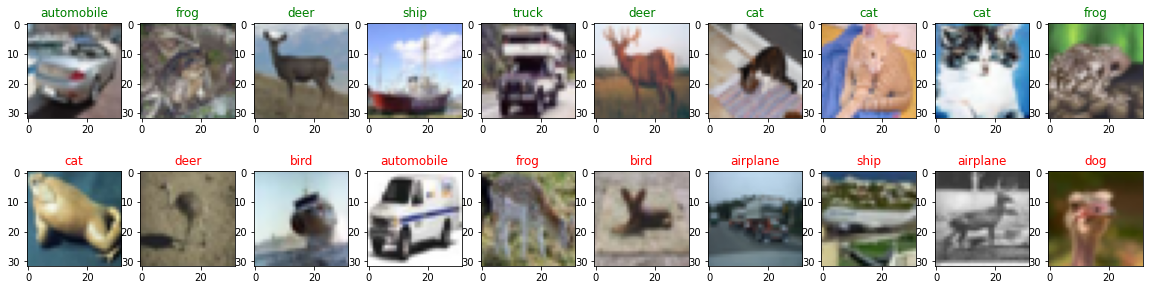

In [22]:
plot_predictions(X_test_normalized, cnn_model, class_name=None)

##Finetuning (2 Points)
In the next step we want to use a model which is already pretrained on a large dataset (Imagenet) and finetune it for the CIFAR10 dataset. Keras already provides us with multiple pretrained models (see https://keras.io/applications/). Your task is to take the ResNet50 model and **only** retrain the last layer. You should upsample the images first because ResNet is trained on Images with the resolution of (224, 224). However training with this resolution takes very long with not that much gain. A resolution of (128, 128) is a good compromise between accuracy and training time. You can use the `UpSampling2D` layer of Keras. You should also preprocess the images the same way as ResNet using the function `preprocess_input` from the ResNet50 library. This approach should get you to over 80% of validation accuracy. Training time will take much longer here (~120 seconds per epoch), so we will only train for 5 epochs. 

In [11]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input


########## Fix This Part ##########
# Original 32 -> Target 128: Factor 4
X_train_resnet = preprocess_input(layers.UpSampling2D(size=4)(X_train))
X_test_resnet = preprocess_input(layers.UpSampling2D(size=4)(X_test))

resnet_input = layers.Input(shape=X_train_resnet[0].shape)
resnet_layers = ResNet50(include_top=False, weights="imagenet",pooling="avg")


for single_layer in resnet_layers.layers:
  single_layer.trainable = False

resnet_layers.layers[-1].trainable = True
resnet_out = resnet_layers(resnet_input)

resnet_predictions = layers.Dense(10, activation="softmax")(resnet_out)

###################################

resnet_model = Model(inputs=resnet_input, outputs=resnet_predictions)
resnet_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

resnet_model.summary()
history_resnet=resnet_model.fit(x=X_train_resnet, 
                          y=y_train_onehot, 
                          validation_data=(X_test_resnet, y_test_onehot),
                          epochs=5)  # starts training

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/5
1563/1563 [==============================] - 48s 31ms/step - loss: 0.8191 - accuracy: 0.7206 - val_loss: 0.7592 - val_accuracy: 0.7476
Epoch 2/5
1563/1563 [==============================] - 48s 30ms/step - loss: 0.6203 - accuracy: 0.7886 - val_loss: 0.6632 - val_accuracy: 0.7804
Epoch 3/5
1563/1563 [==============================] - 53s 34ms/step - loss: 

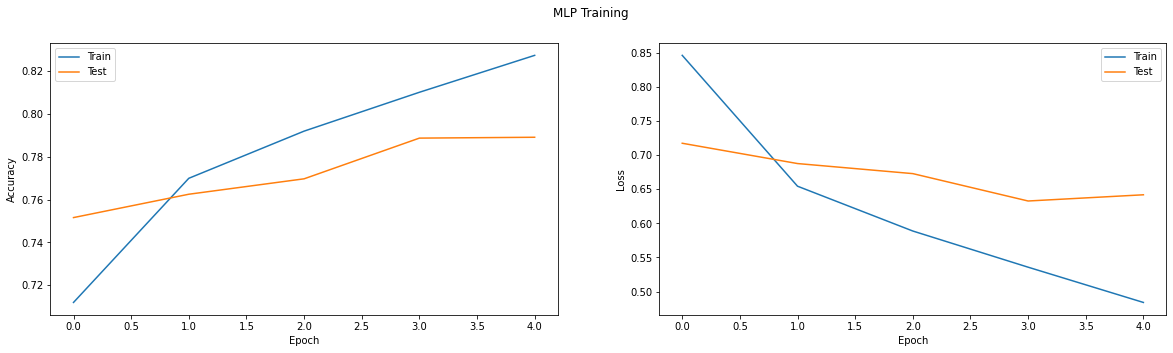

In [11]:
plot_history(history_resnet)

# Experiments
Here you can add code that you need for your documentation. Feel free to play around in this section with the models, your own images, create new models, data augmentation, different datasets, ...



In [12]:
# Create an optimizer and then reload weights we saved earlier.
my_sgd = optimizers.SGD(learning_rate=0.001)
mlpreg_model.load_weights('mlpreg_model_weights.h5')

In [13]:

mlpreg_model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
mlpreg_model.summary()
history_mlpreg = mlpreg_model.fit(x = X_train_vector, 
                          y = y_train_onehot, 
                          validation_data = (X_test_vector, y_test_onehot), 
                          epochs = 30)  # starts training

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
________________________________________________

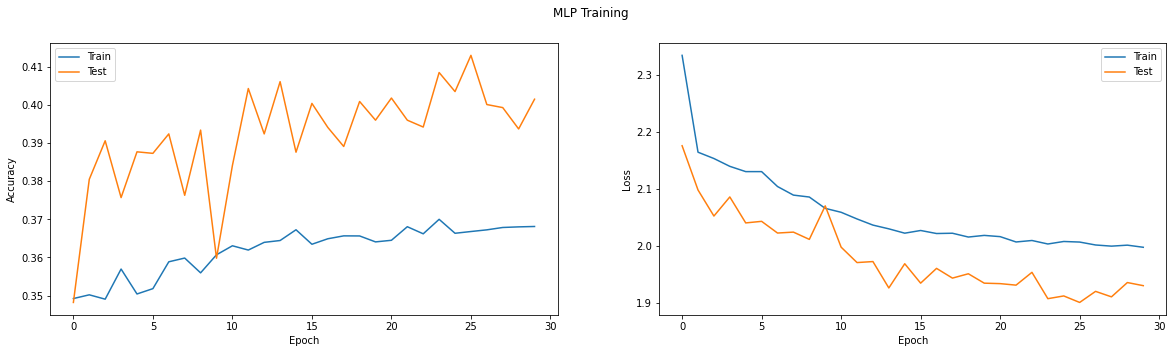

In [29]:
plot_history(history_mlpreg)

In [67]:
# Image 1
test_im = load_image_link('https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Fallow_deer_in_field.jpg/1200px-Fallow_deer_in_field.jpg')

In [70]:
# Image 2
test_im = load_image_link('https://files.osgnetworks.tv/3/files/how-to-understand-whitetail-deer-sounds/005_snort-wheeze.jpg')

In [73]:
# Image 3
test_im = load_image_link('https://www.wallpapers4u.org/wp-content/uploads/horse_grass_meadow_brown_black_35937_1920x1080-450x253.jpg')

[[3.5148170e-03 7.6883711e-04 4.4870409e-01 1.9761368e-03 5.0186723e-01
  8.1998780e-03 5.5871317e-03 2.0764936e-02 8.4698731e-03 1.4715428e-04]]
Top-5 Predictions:
  Deer - 50.19 %
  Bird - 44.87 %
  Horse - 2.08 %
  Ship - 0.85 %
  Dog - 0.82 %


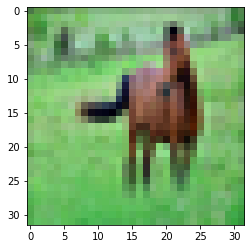

In [74]:
# Show image and MLP predictions
plt.imshow(test_im[0,...])
test_im = normalize_images(X_train, test_im)[1]
vec_im = vectorize_images(test_im)
predict_image(one_layer_model, vec_im)

In [75]:
# Show CNN predictions
predict_image(cnn_model, test_im)

[[6.5302665e-09 1.2401230e-12 2.1727916e-03 5.5859116e-05 3.3167776e-02
  9.9156708e-02 2.9050035e-10 8.6544693e-01 9.0093704e-13 1.4666181e-10]]
Top-5 Predictions:
  Horse - 86.54 %
  Dog - 9.92 %
  Deer - 3.32 %
  Bird - 0.22 %
  Cat - 0.01 %


In [ ]:
# If you want to mount your Google Drive to store weights or plots for example
# you can use the commands below. Check this link for more information:
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')